# **Factory Machine Failure Classification**

Author: Kaleb Nim

## Project Objective:

> Using Machine Learning classification model to solve Binary Class classification problem: Predict if a Machine will fail or not fail 



### Background information 
Dataset collected from a factory environment. Inside the factory, there are 
many machines and components, and they might break down after using for some 
time. Therefore, it is useful to build a prediction model in order to predict which 
machine / component will possibly fail before it actually fails, so that the technician can 
replace it without interruption the production.

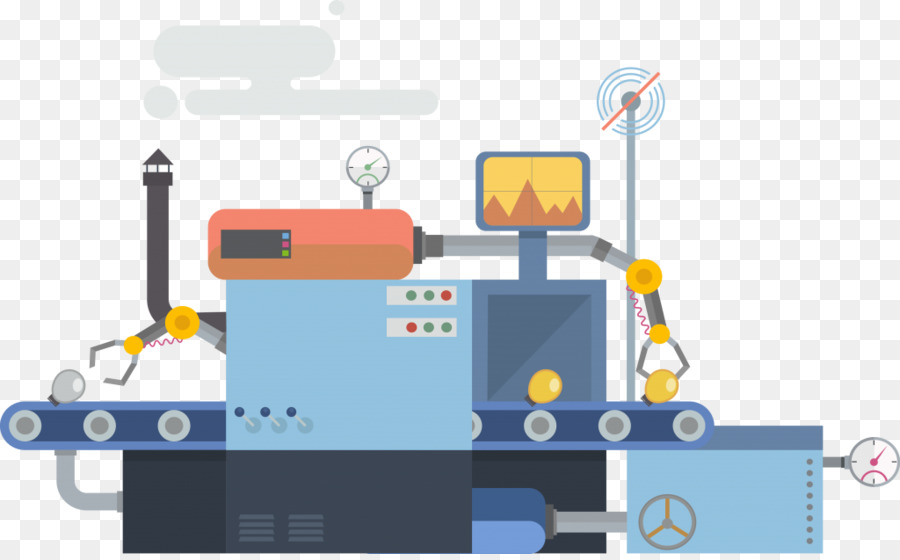

# **Project Initilzation**

## Importing Libraries

In [ ]:
!pip uninstall sklearn -y
!pip install Cython
!pip install -U scikit-learn
!pip install phik


Found existing installation: sklearn 0.0
Uninstalling sklearn-0.0:
  Successfully uninstalled sklearn-0.0
     |████████████████████████████████| 690 kB 5.1 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import time as time
# Models
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, learning_curve ,cross_val_score ,GridSearchCV,KFold,RandomizedSearchCV

# algorithm family :D 
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,RandomForestRegressor
import xgboost

import sklearn
print(sklearn.__version__)
# Date preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer ,SimpleImputer ,IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler 
from sklearn.compose import ColumnTransformer

# Model Evaluation Metrics
from sklearn.metrics import fbeta_score, make_scorer,classification_report,confusion_matrix, roc_auc_score, f1_score ,plot_confusion_matrix ,accuracy_score,recall_score,precision_score,plot_roc_curve,fbeta_score
# progress bar
from tqdm import tqdm

# Bivariative Analysis
# !pip install phik
import phik
from phik import resources, report

1.0.2


## Loading Dataset

In [ ]:
df_raw = pd.read_csv('/content/drive/MyDrive/Datasets/factory_data (classification).csv')
df_raw.head()

,Unique ID,Product ID,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
0,1,K12965,M,24.95,35.45,1551.0,42.8,0,0
1,2,Z62710,L,25.05,35.55,1408.0,46.3,3,0
2,3,T20224,L,24.95,35.35,1498.0,49.4,5,0
3,4,Z33024,L,25.05,35.45,1433.0,39.5,7,0
4,5,Z52839,L,25.05,35.55,1408.0,40.0,9,0


## Data Dictonary

|     **Column**     	|                                **Description**                               	|
|:------------------:	|:----------------------------------------------------------------------------:	|
| Unique ID          	| Unique identifier ranging from 1 to 20000                                    	|
| Product ID         	| The serial number of product                                                 	|
| Quality            	| Consist of letter L, M and H for low, medium and high quality                	|
| Ambient T          	| Environment temperature in degree celsius                                    	|
| Process T          	| Machine temperature                                                          	|
| Rotation Speed     	| Rotational speed of machine when running                                     	|
| Torque             	| Measure of the turning force                                                 	|
| Tool Wear          	| Tool wear time estimated for the machine                                     	|
| **Machine Status** 	| **Labels indicate machine failure or not, 1 means failure, 0 means normal.** 	|

# Prevent Data Leakage 



> **Data leakage** is when information from outside the training dataset is used to create the model. This additional information can allow the model to learn or know something that it otherwise would not know and in turn invalidate the estimated performance of the mode being constructed.
Reference : [data-leakage-machine-learning](https://machinelearningmastery.com/data-leakage-machine-learning/)

To takle this problem I'll be creating a **Holdout Dataset** that will be left untouched in all data preprocessing and model training to act as a final sanity check of my finalizated model.


In [ ]:
train_df,test_df = train_test_split(df_raw,test_size=0.2,random_state=1)
print(f'Shape of train_df:{train_df.shape}\nShape of test_df:{test_df.shape}')

Shape of train_df:(16000, 9)
Shape of test_df:(4000, 9)


# **Exploratory Data Analysis**

A good data science project starts from understanding your data. With that, I 
will perform some basic visualisation to spot some trends and errors in the machine dataset.

---

To prevent the mutation of our original data, we will make a copy of our data to perform eda on it.

*EDA process will only be analysed to the train_df*

In [ ]:
df_eda = train_df.copy()

## Descriptive Statistics

In [ ]:
df_eda.shape

(16000, 9)

There are **16k** rows and **9** Features in the training factory datset

In [ ]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16000 entries, 7013 to 235
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unique ID             16000 non-null  int64  
 1   Product ID            16000 non-null  object 
 2   Quality               15208 non-null  object 
 3   Ambient T (C)         16000 non-null  float64
 4   Process T (C)         15687 non-null  float64
 5   Rotation Speed (rpm)  15055 non-null  float64
 6   Torque (Nm)           16000 non-null  float64
 7   Tool Wear (min)       16000 non-null  int64  
 8   Machine Status        16000 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 1.2+ MB


It is to be noted that features:

`Ambient T (C)`, `Process T (C)`, `Rotation Speed (rpm)` and `Tool Wear (min)` are **Quantitative** features

`Quality` is a **nominally valued categorical** feature

## Pairplot

Since our feature space is not extremely large, we can afford to plot out a Pairplot to visualise the distribution of datapoints with relation to Target variable `Machine Status` 

I hope to Answer the following questions:



1.   Is there a noticable pattern relating Machine Status with Quantitave variables like Ambient T and Process T
2.   List item



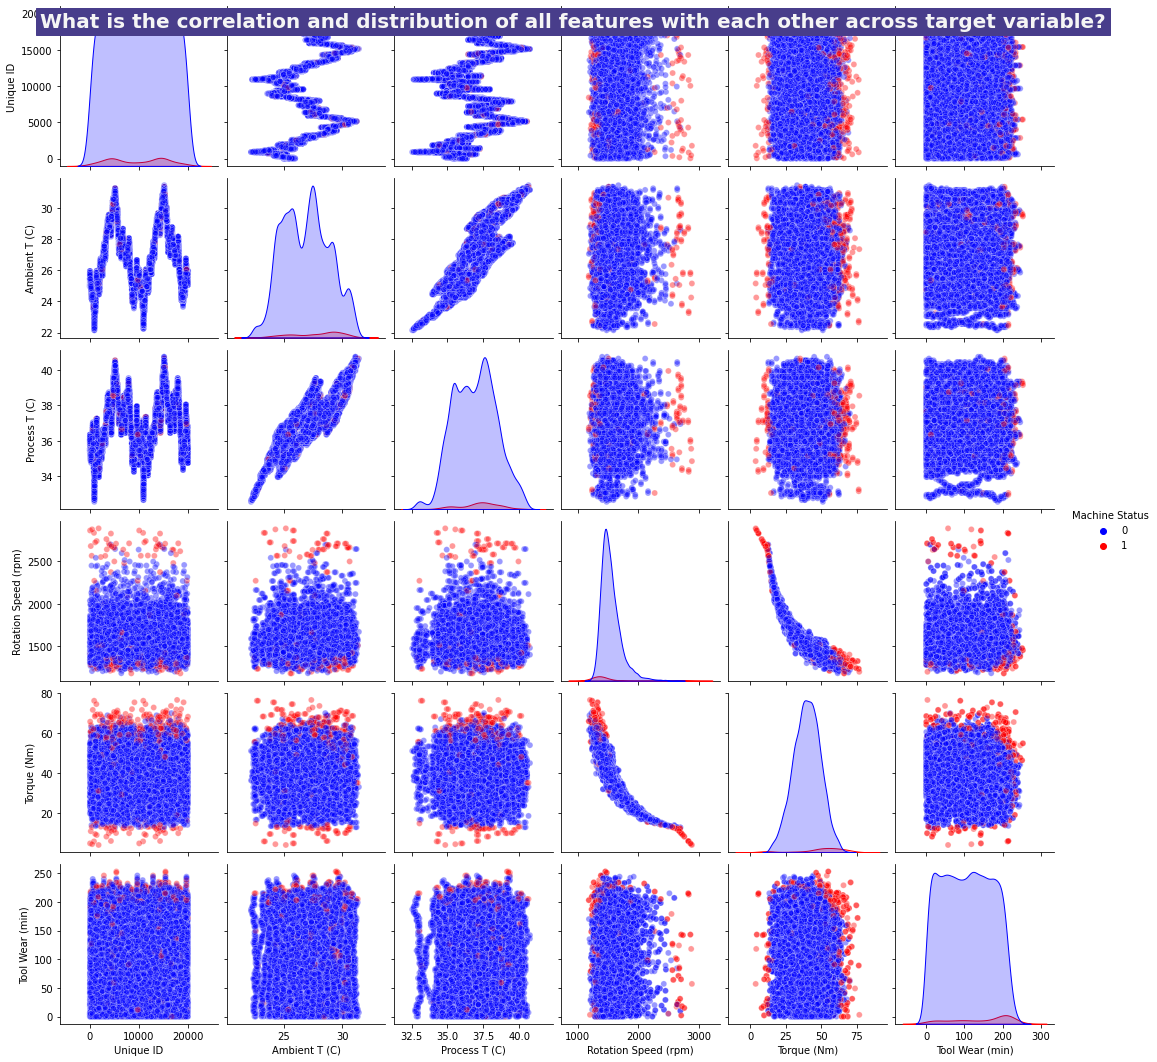

In [ ]:
g = sns.pairplot(df_eda.drop(columns=['Product ID']), hue = 'Machine Status', palette=['b', 'r'], plot_kws=dict(alpha=0.4))
# Add title
g.fig.suptitle("What is the correlation and distribution of all features with each other across target variable?", color='whitesmoke',weight='bold',size=20, backgroundcolor= 'darkslateblue')
plt.show()

### Pairplot Observations:



*   Generally, Machine failure occurs at extreme ends of features
*   A pattern whereby alot of Machine Failure occurs when `Torque` is above 70Nm or below 20Nm. This can be seen across all other features 
*   A similar pattern can also be seen with extreme values of `Rotation speed` above 2500Rpm and around below 1300rpm



INSERT MATH EXPLANATION FOR PHIK THINGY

In [ ]:
df_eda.phik_matrix()

interval columns not set, guessing: ['Unique ID', 'Ambient T (C)', 'Process T (C)', 'Rotation Speed (rpm)', 'Torque (Nm)', 'Tool Wear (min)', 'Machine Status']


/usr/local/lib/python3.7/dist-packages/phik/data_quality.py:62: UserWarning: The number of unique values of variable Product ID is large: 15621. Are you sure this is not an interval variable? Analysis for pairs of variables including Product ID can be slow.
  col, df[col].nunique()


,Unique ID,Product ID,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
Unique ID,1.000000,0.262634,0.024757,0.856041,0.759167,0.053805,0.000000,0.000000,0.148457
Product ID,0.262634,1.000000,0.000000,0.000000,0.000000,0.668248,0.796228,0.000000,0.000000
Quality,0.024757,0.000000,1.000000,0.038477,0.038276,0.034503,0.030879,0.000000,0.020323
Ambient T (C),0.856041,0.000000,0.038477,1.000000,0.924075,0.074725,0.080081,0.114700,0.152627
Process T (C),0.759167,0.000000,0.038276,0.924075,1.000000,0.070861,0.064725,0.121721,0.084732
Rotation Speed (rpm),0.053805,0.668248,0.034503,0.074725,0.070861,1.000000,0.937281,0.066125,0.466114
Torque (Nm),0.000000,0.796228,0.030879,0.080081,0.064725,0.937281,1.000000,0.054576,0.600269
Tool Wear (min),0.000000,0.000000,0.000000,0.114700,0.121721,0.066125,0.054576,1.000000,0.275976
Machine Status,0.148457,0.000000,0.020323,0.152627,0.084732,0.466114,0.600269,0.275976,1.000000


Torque and Rotation Speed has the highest correlation score compared to all other features at 0.60 and 0.46 respectively

This is supported by the pairplot graphs. ( IDK ADD MORE EXPLANATION HERE ) 

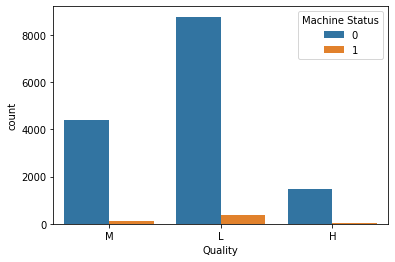

In [ ]:
sns.countplot(data=df_eda,x='Quality',hue='Machine Status')

## Outlier Values

## Distribution of Target Variable

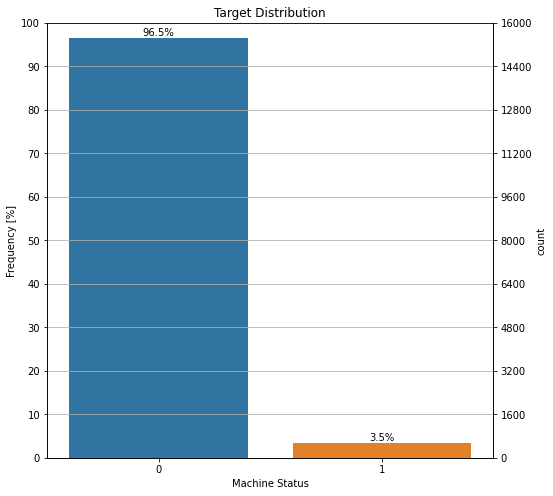

In [ ]:
import matplotlib.ticker as ticker

ncount = len(df_eda)

plt.figure(figsize=(8,8))
ax = sns.countplot(x="Machine Status", data=df_eda)
plt.title('Target Distribution')

# Make twin axis
ax2=ax.twinx()

# Switch so count axis is on right, frequency on left
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the frequency range to 0-100
ax2.set_ylim(0,100)
ax.set_ylim(0,ncount)

# And use a MultipleLocator to ensure a tick spacing of 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
ax2.grid(None)

### Observations:

> Our Target Feature `Machine Status` has an extremely **uneven distribution** of observations i.e No Machine faiilure has a very high number of observations whereas Machine failure has a very low number of observations at 96.5% and 3.5% respectively

From this we can conclude that we are working with an **Imbalanced dataset**

Thus we have to be carefull when selecting a Evaluation Metric for our models. ( more will be explaned in the Evalutaion Metric selction of this workbook ) 


## Checking for Null Values

In [ ]:
null_features = df_eda.isna().sum() > 0 
print(df_eda.isna().sum()[null_features])

Quality                 792
Process T (C)           313
Rotation Speed (rpm)    945
dtype: int64


### Visuallizing Null values

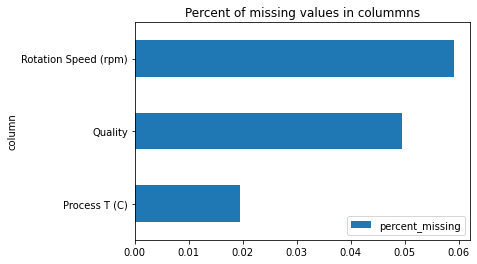

In [ ]:
def plot_missing_values(df):
    """ For each column with missing values plot proportion that is missing."""
    data = [(col, df[col].isnull().sum() / len(df)) 
            for col in df.columns if df[col].isnull().sum() > 0]
    col_names = ['column', 'percent_missing']
    missing_df = pd.DataFrame(data, columns=col_names).sort_values('percent_missing')
    missing_df.plot(kind='barh', x='column', y='percent_missing'); 
    plt.title('Percent of missing values in colummns');

plot_missing_values(df_eda)

# **Feature Processing**

In [ ]:
df = train_df.copy()

## Feature Selection


By performing feature selection on my data will allow me to accomplish the following:

*   Reduce Overfitting 

    Less redundant data means less opportunity to make decisions based on noise --> Improves Accuracy

*   Reduce the computational cost of modeling

    Less data means that algorithms train faster.


### Which features to select?

Based on above EDA, `ProductID` has a 0.00 correlation score and `	Process T (C) `has a 0.08 in the phik matric ( EXPLAIN BETTER KAYY )  Therefore, we will remove both features and select the rest.

In [ ]:
# Drop columns ProductID and Process T (C)
df = df.drop(['Product ID'], axis = 1) 

In [ ]:
df.columns

Index(['Unique ID', 'Quality', 'Ambient T (C)', 'Process T (C)',
       'Rotation Speed (rpm)', 'Torque (Nm)', 'Tool Wear (min)',
       'Machine Status'],
      dtype='object')

## Extracting Features, `X` and Target Variable, `y`

In [ ]:
X = df.drop(columns=['Machine Status'])
y = df['Machine Status']

In [ ]:
X

,Unique ID,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min)
7013,7014,M,27.25,37.25,1544.0,36.3,21
7766,7767,L,27.15,38.25,1318.0,52.7,13
5910,5911,M,27.65,37.15,1458.0,43.4,0
7020,7021,L,27.65,37.65,1460.0,53.8,41
16952,16953,L,27.75,38.25,1498.0,40.2,73
...,...,...,...,...,...,...,...
10955,10956,L,22.55,33.25,1911.0,20.9,74
17289,17290,L,27.25,37.55,1433.0,53.8,86
5192,5193,L,30.75,39.95,1310.0,62.9,130
12172,12173,L,26.45,36.15,NaN,23.0,15


In [ ]:
y

7013     0
7766     0
5910     0
7020     0
16952    0
        ..
10955    0
17289    0
5192     0
12172    0
235      0
Name: Machine Status, Length: 16000, dtype: int64

In [ ]:
# Import train_test_split function from sklearn library

X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=42)

In [ ]:
print(X_train.shape,X_test.shape)

(11200, 7) (4800, 7)


In [ ]:
df.isna().sum()

Unique ID                 0
Quality                 792
Ambient T (C)             0
Process T (C)           313
Rotation Speed (rpm)    945
Torque (Nm)               0
Tool Wear (min)           0
Machine Status            0
dtype: int64

Features `Quailty` , `Process T (C)` and `Rotation Speed (rpm)` have missing values

 ## Handling Missing Values 
There's a few ways we could go about handing missing values



1.   Dropping entire rows with Missing values
2.   Impute with Central Tendency ( Mean, Median, Mode )
3.   Impute with Advanced Algorithm in SKLearn ( IterativeImputer, KNNImputer )


EXPLAIN WHY U CHOOSE WHAT KAY



In [ ]:
# All Numerical Features that has missing Values
num_cols = [
'Rotation Speed (rpm)',
'Process T (C)'
]

# initialize Imputer
imputer = IterativeImputer()
imputed = imputer.fit_transform(X_train[num_cols])

X_train.loc[:, num_cols] = imputed

imputed = imputer.transform(X_test[num_cols])

X_test.loc[:,num_cols] = imputed

In [ ]:
X_train.isna().sum()

Unique ID                 0
Quality                 552
Ambient T (C)             0
Process T (C)             0
Rotation Speed (rpm)      0
Torque (Nm)               0
Tool Wear (min)           0
dtype: int64

In [ ]:
# Categorical Features that has missing Values 

cat_cols = ['Quality']

# Initialze Imputer by most Frequent
imp = SimpleImputer(strategy='most_frequent')
imputed_cat = imp.fit_transform(X_train[cat_cols])

X_train.loc[:, cat_cols] = imputed_cat

imputed_cat = imp.transform(X_test[cat_cols])

X_test.loc[:,cat_cols] = imputed_cat

In [ ]:
X_test.isna().sum()

Unique ID               0
Quality                 0
Ambient T (C)           0
Process T (C)           0
Rotation Speed (rpm)    0
Torque (Nm)             0
Tool Wear (min)         0
dtype: int64

Adding 

## Adding new features

We will be adding two new features:

Horsepower: 

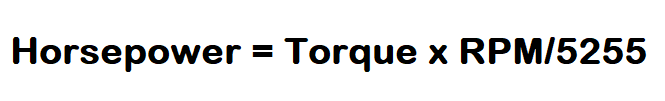

Temperature Difference:

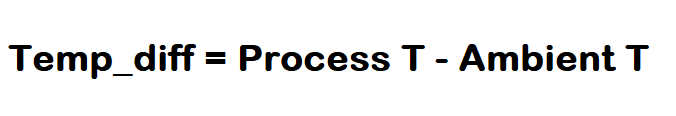


In [ ]:
X_train['horsepower'] = X_train['Torque (Nm)']*(X_train['Rotation Speed (rpm)']/5255)


X_test['horsepower'] = X_test['Torque (Nm)']*(X_test['Rotation Speed (rpm)']/5255)


In [ ]:
X_train

,Unique ID,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),horsepower
73,74,L,25.85,35.95,1539.864933,35.0,200,10.255999
19495,19496,H,26.25,36.95,1373.000000,44.8,221,11.705119
16437,16438,L,27.35,36.95,1282.000000,66.1,40,16.125633
11582,11583,H,25.05,35.25,1530.000000,42.0,184,12.228354
9116,9117,H,24.45,35.55,1659.000000,32.1,49,10.133949
...,...,...,...,...,...,...,...,...
1082,1083,H,23.95,34.75,1420.000000,39.8,192,10.754710
4555,4556,L,29.55,37.45,1690.000000,26.7,4,8.586679
13391,13392,L,28.45,37.65,1541.378114,47.3,77,13.873870
8667,8668,M,24.35,35.65,1455.000000,46.1,147,12.764129


## Normalizing Data

Normalizing or preprocessing the data will help many models perform better
after this is done. 
( Except Tree Models as it treats each feature on its own )


### For this particular dataset I'm are going to **Standardize** the data. 



> Standardizing is translating the data so that it has a mean value of zero and a standard deviation of one. Refrence: [Data Standardization](https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/#:~:text=Standardizing%20a%20dataset%20involves%20rescaling,value%20or%20centering%20the%20data.)



This way models don’t treat variables with larger scales as more
important than smaller scaled variables.

In [ ]:
# Initialize StandardScaler class
scaler = StandardScaler()

num_col = ["Ambient T (C)" ,"Rotation Speed (rpm)", "Torque (Nm)", "Tool Wear (min)","horsepower"]

# Save a copy of X_train before Standardization to plot before and after for comparism 
X_train_copy = X_train.copy()

# Fit and transform training and test sets to standardize numercial values 
X_train[num_col] = scaler.fit_transform(X_train[num_col] )
X_test[num_col] = scaler.fit_transform(X_test[num_col] )

### End ###
X_train

,Unique ID,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),horsepower
73,74,L,-0.540491,35.95,-0.004855,-0.489496,1.446877,-0.572849
19495,19496,H,-0.339462,36.95,-0.947422,0.488676,1.776523,0.144480
16437,16438,L,0.213369,36.95,-1.461452,2.614702,-1.064712,2.332678
11582,11583,H,-0.942550,35.25,-0.060579,0.209198,1.195718,0.403486
9116,9117,H,-1.244094,35.55,0.668102,-0.778955,-0.923435,-0.633265
...,...,...,...,...,...,...,...,...
1082,1083,H,-1.495381,34.75,-0.681934,-0.010391,1.321298,-0.325982
4555,4556,L,1.319032,37.45,0.843211,-1.317947,-1.629820,-1.399179
13391,13392,L,0.766201,37.65,0.003693,0.738209,-0.483907,1.218033
8667,8668,M,-1.294352,35.65,-0.484230,0.618433,0.614913,0.668700


### Visuallazing Standardization

By plotting a histogram of distribution of any one of the numerical features before Standardized and after Standardized

In [ ]:
# Using Feature Torque (Nm) Before Standardization
import plotly.express as px
df = px.data.tips()
fig = px.histogram(X_train_copy, x="Torque (Nm)", nbins=30,title="Distribution of Torque (Nm) Before Standardization")
fig.show()

In [ ]:
# Using Feature Torque (Nm) after Standardization
import plotly.express as px
df = px.data.tips()
fig = px.histogram(X_train, x="Torque (Nm)", nbins=30,title="Distribution of Torque (Nm) After Standardization")
fig.show()

### **Observations**:

Even though the shape of distribution of Torque didn't change, the X-axis values changed. 

After Standardization, 

*   mean value has change from 40 to 0
*   Range from (10 --> 70) to (-3 --> 3)



## Feature Encoding

ML models we are often required to convert the categorical i.e text features to its numeric representation.

We have two choices for Categorical Encoding 



*   One-Hot-Encoding
*   Label Encoding

The feature we want to encode is `Quality`. Which consists of `['L', 'H', 'M']` ( as seen below ) stands for Low Medium and High Quality respectively

Conclusion: Since `Quality` is a Ordinal feature, we will choose **Label Encoding** as we want the model to derive a correlation between the Quality number increases and machine failure prediction

In [ ]:
#List unique value of flat_type with unique()
X_train['Quality'].unique()

array(['L', 'H', 'M'], dtype=object)

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoded = LabelEncoder()
encoded.fit([
        ['M'],
        ['L'],
        ['H']
    ])
X_encoded_train = encoded.fit_transform(X_train[["Quality"]])
X_encoded_test = encoded.fit_transform(X_test[["Quality"]])

### End ###
X_train['Quality'] = X_encoded_train
X_test['Quality'] = X_encoded_test
X_train

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



,Unique ID,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),horsepower
73,74,1,-0.540491,35.95,-0.004855,-0.489496,1.446877,-0.572849
19495,19496,0,-0.339462,36.95,-0.947422,0.488676,1.776523,0.144480
16437,16438,1,0.213369,36.95,-1.461452,2.614702,-1.064712,2.332678
11582,11583,0,-0.942550,35.25,-0.060579,0.209198,1.195718,0.403486
9116,9117,0,-1.244094,35.55,0.668102,-0.778955,-0.923435,-0.633265
...,...,...,...,...,...,...,...,...
1082,1083,0,-1.495381,34.75,-0.681934,-0.010391,1.321298,-0.325982
4555,4556,1,1.319032,37.45,0.843211,-1.317947,-1.629820,-1.399179
13391,13392,1,0.766201,37.65,0.003693,0.738209,-0.483907,1.218033
8667,8668,2,-1.294352,35.65,-0.484230,0.618433,0.614913,0.668700


# **Modelling**

We will be using pipelines to smoothen the process

## Selecting Evaluation Metrics

As we seen in our EDA above the dataset is highly imbalanced with 96.5% machines being functional and only 3.5% machine failure. Which can cause some issue

For example using **Accuracy score**: 

> The model predicts all machines are functional. The model will be highly evaluated with accuracy score of 96.5% even though its absolutely horrenderous at the main goal of predicting machine failure.

Since our goal is to build a model to succesfully **predict Machine Failure** --> we need a metrics that heavily penalized FP ( false positives ) i.e Model predicts machine is functional but actual result is machine failure (FP)



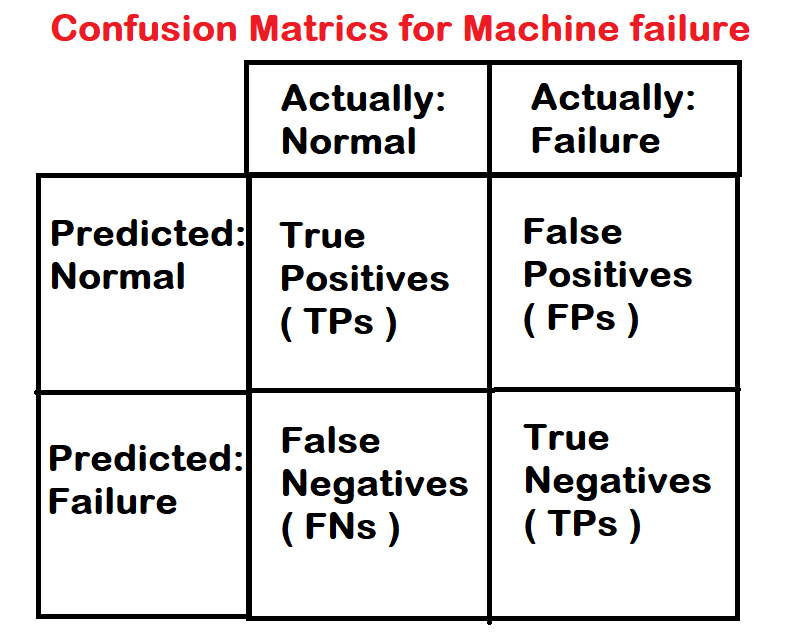

### List of all the possible evalutation Metrics


*   Accuracy

    - Percent of correct predictions

* precision
    - Ability to find only relevant samples (not label a negative
      as a positive)

* recall
  - Ability to find all positive samples

*  'f1-score'
    - Harmonic mean of precision and recall

* 'fβ-score'
    - Same as f1-score but able to assign different weights to prescision and recall 

* 'roc_auc'
    - Area under the receiver operator characteristic curve

* Precision-Recall Curve


For the case of

## RandomForestClassifier

## Stupid Baseline Model



In [ ]:
start_time = time.time()

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")



In [ ]:
def display_dummy_classidier(X_train,y_train,X_test,y_test,strategy=str):
  dummy_clf = DummyClassifier(strategy="uniform")
  dummy_clf.fit(X_train, y_train)
  DummyClassifier(strategy=strategy)
  prediction = dummy_clf.predict(X_test)
  # print(f"Test F1 Score\t:{f1_score(y_test,prediction)}") # Test F1 Score
  print(f"Strategy:{strategy}\n{classification_report(y_test, prediction, target_names=['train','test'])}\n")

strategies = ["most_frequent", "prior", "stratified", "uniform", "constant"]
start_time = time.time()

for i in strategies:
  display_dummy_classidier(X_train,y_train,X_test,y_test,strategy=i)

  
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Strategy:most_frequent
              precision    recall  f1-score   support

       train       0.96      0.50      0.66      4619
        test       0.04      0.54      0.07       181

    accuracy                           0.50      4800
   macro avg       0.50      0.52      0.37      4800
weighted avg       0.93      0.50      0.63      4800


Strategy:prior
              precision    recall  f1-score   support

       train       0.96      0.50      0.66      4619
        test       0.04      0.49      0.07       181

    accuracy                           0.50      4800
   macro avg       0.50      0.50      0.36      4800
weighted avg       0.93      0.50      0.64      4800


Strategy:stratified
              precision    recall  f1-score   support

       train       0.96      0.50      0.66      4619
        test       0.04      0.50      0.07       181

    accuracy                           0.50      4800
   macro avg       0.50      0.50      0.36      4800
weighted avg  

## Quick model evaluation

In [ ]:
def plot_learning_curve(model, X, y, scoring, cv = StratifiedKFold(shuffle=True, random_state = 42), train_sizes = np.linspace(.1, 1.0, 10)):
  try:
    model_name = type(model[-1]).__name__ 
  except:
    model_name = type(model).__name__
  fig, ax = plt.subplots(figsize=(10, 8))
  train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv = cv, n_jobs = -1, train_sizes = train_sizes, scoring=scoring)
  scores = pd.DataFrame({
      "Train Sizes" : np.tile(train_sizes, train_scores.shape[1]),
      "Train Scores" : train_scores.flatten(),
      "Test Scores" : test_scores.flatten()
  }).melt(value_vars=["Train Scores", "Test Scores"], var_name="Score Type", value_name="Scores", id_vars=["Train Sizes"])
  sns.lineplot(data=scores, x="Train Sizes", y="Scores", hue="Score Type", ax = ax)
  ax.set_title(f"Learning Curve of {model_name}")
  ax.set_ylabel(f"{scoring}")
  ax.set_xlabel("Train Sizes")
  return fig

In [ ]:
def model_evalutate(model,X,y,metrics=["precision","recall","f1","roc_auc"],cv = KFold(n_splits=5,shuffle=True,random_state=1),model_name = None , history=pd.DataFrame()):
  scores = cross_validate(model,X,y,cv=cv,scoring = metrics,return_estimator=True,n_jobs=-1)
  scores = pd.DataFrame(scores).describe().iloc[1:3.2:].round(5)
  sns = plot_learning_curve(model,X,y,scoring=f1_score,cv=cv)
  return scores,sns

# Evaluating Models
To Streamline the modeling process over muplitle Algorithms we will create a Utility Function 

## How do we select the best model for this project?



*   ### Learning Curve

  *  Analyze/explore the bias and variance of a model. --> Check Model Underfitted/Overfitted

*  ### K-Fold Cross-Validation
  * avoid overfitting and estimate the skill of the model on new data.




### Use of Cross-Validation to evalutate 

## Learning Curve

We will also be plotting a Learning Curve, which will be used to analyze the bias and variance of a model.
https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

In [ ]:
# Utility Function 
def evaluate_model(models, X_train, X_test, y_train, y_test,metrics=["precision","recall","f1","roc_auc"],cv = KFold(n_splits=5,shuffle=True,random_state=1)):
    hist = {}
    
    for idx, model in (enumerate(models)):
        try:
            clf = model(random_state=42,max_iter=300,class_weight='balanced') # Setting random_state for certain model + set class rate to balanced 
        except:
            clf = model()
        clf.fit(X_train, y_train)
        train_prediction = clf.predict(X_test)

        f1_test = f1_score(y_test, train_prediction,zero_division=1)
        f1_beta = fbeta_score(y_test, train_prediction,zero_division=1,beta= 2) # 𝛽 = 2, weighs Recall higher than Precision.
        
        # 5-Fold CV
        cv_hist = cross_validate(clf, X_train, y_train, scoring=metrics)

        # Record down the performance
        hist[model.__name__] = dict(
            # train_acc = acc_train,
            cv_precision = cv_hist['test_precision'].mean(),
            cv_recall = cv_hist['test_recall'].mean(),
            cv_f1_score = cv_hist['test_f1'].mean(),
            f1_test_score = f1_test,
            f1_beta_test_score = f1_beta,
            cv_auc = cv_hist['test_roc_auc'].mean()
        )
        # print(f"this is hist:\n{hist}")
        predictions = clf.predict(X_test)
        # print(classification_report(y_test,predictions))

        # Plotting the learning Curve of each Model --F1_score
        fig, ax = plt.subplots(figsize=(10, 8))
        train_sizes = np.linspace(.1, 1.0, 10)
        train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv = cv, n_jobs = -1, train_sizes = train_sizes, scoring="f1")
        scores = pd.DataFrame({
        "Train Sizes" : np.tile(train_sizes, train_scores.shape[1]),
        "Train Scores" : train_scores.flatten(),
        "Test Scores" : test_scores.flatten()
        }).melt(value_vars=["Train Scores", "Test Scores"], var_name="Score Type", value_name="Scores", id_vars=["Train Sizes"])
        # print(f"THis is train_sizes:\n{train_sizes}\n This is train_scores:\n{train_scores}\n This is test_scores:{test_scores}")
        sns.lineplot(data=scores, x="Train Sizes", y="Scores", hue="Score Type", ax = ax)
        ax.set_title(f"Learning Curve of {model}")
        ax.set_ylabel("f1_score")
        ax.set_xlabel("Train Sizes")
        plt.show()
        
    # plt.tight_layout()
    display(pd.DataFrame(hist).T)
    # plt.show()

In [ ]:
clf2 = RandomForestClassifier()
cv_hist2 = cross_validate(clf2, X_train, y_train, scoring=["precision","recall","f1","roc_auc"])
# prediction2 = cv_hist2.predict(X_test)
# print(classification_report(y_test,prediction2))
cv_hist2

{'fit_time': array([1.69308519, 1.61392903, 1.69590187, 1.62925768, 1.65688157]),
 'score_time': array([0.08077574, 0.08622336, 0.09181952, 0.08264542, 0.08453727]),
 'test_f1': array([0.72058824, 0.81818182, 0.8358209 , 0.7480916 , 0.78571429]),
 'test_precision': array([0.80327869, 0.94736842, 0.96551724, 0.89090909, 0.859375  ]),
 'test_recall': array([0.65333333, 0.72      , 0.73684211, 0.64473684, 0.72368421]),
 'test_roc_auc': array([0.9556582 , 0.98258353, 0.97041906, 0.95446116, 0.99042344])}

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv = 5, n_jobs = -1, train_sizes = np.linspace(0.1, 1.0, 5), scoring="f1")

display(train_sizes, train_scores, test_scores)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metri

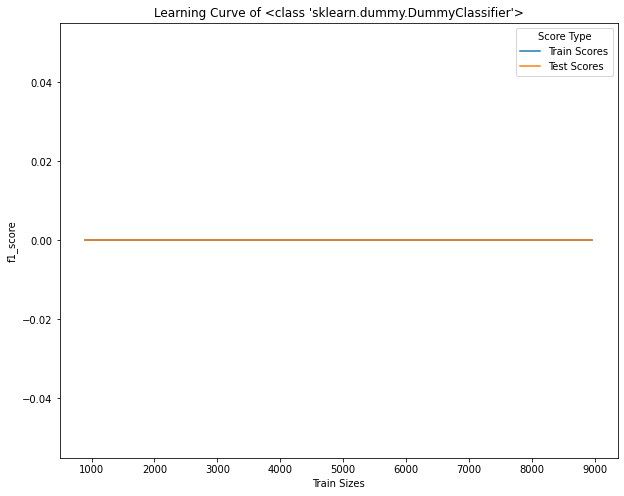

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



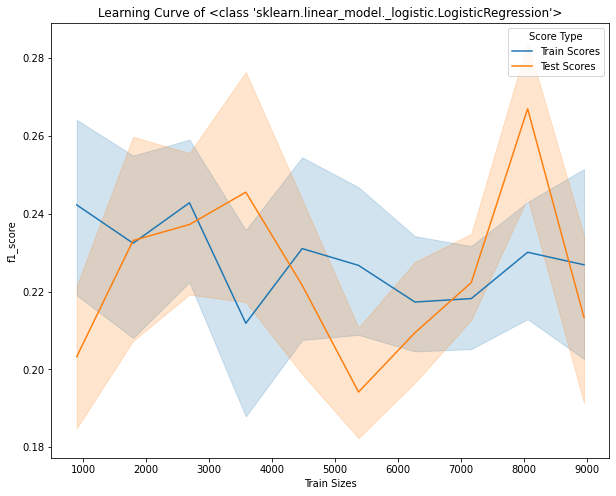

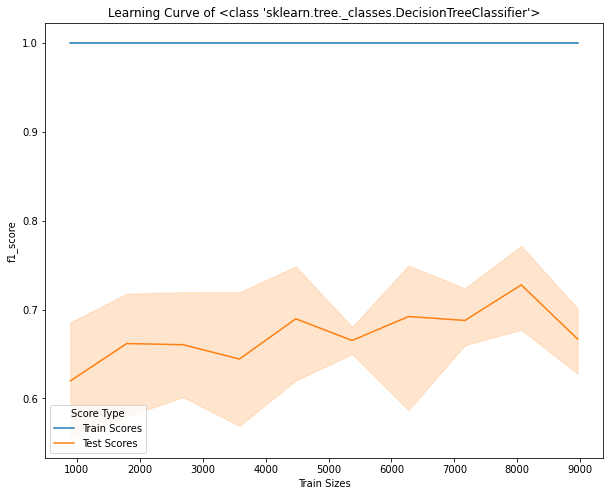

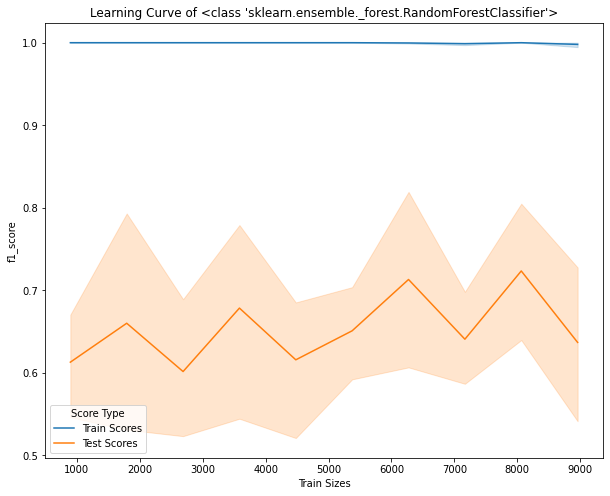

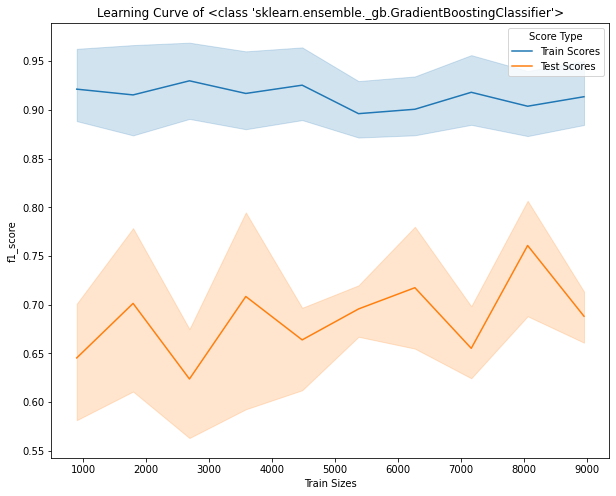

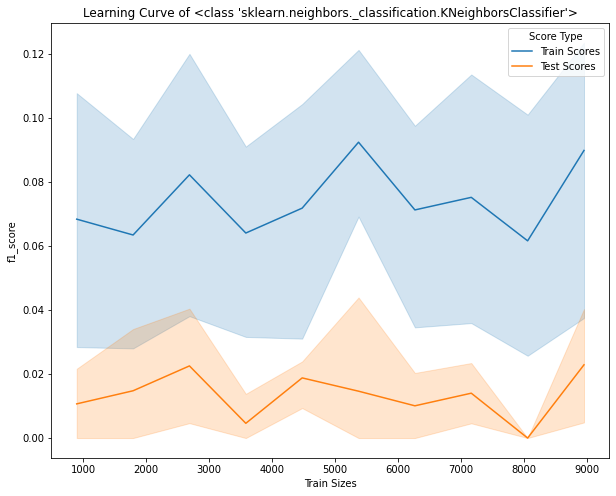

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning:

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning:

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning:

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning:

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning:

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

/usr/

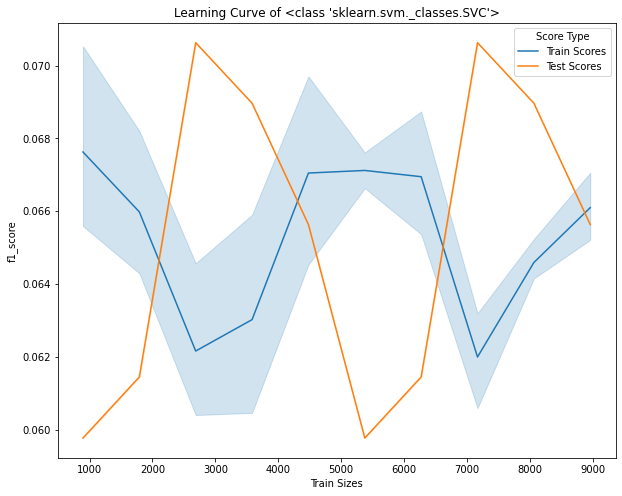

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: C

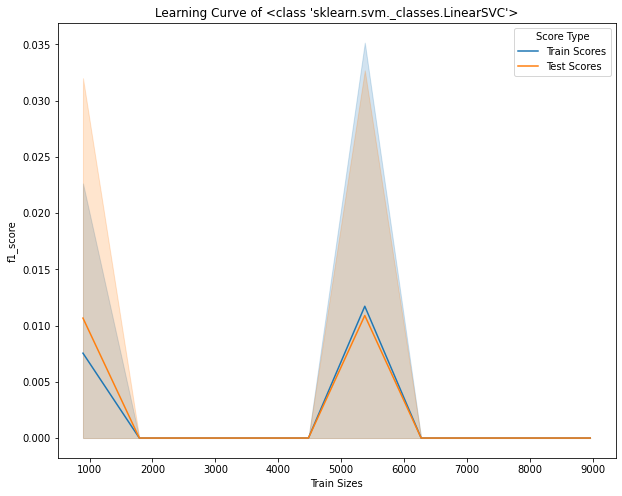

,cv_precision,cv_recall,cv_f1_score,f1_test_score,f1_beta_test_score,cv_auc
DummyClassifier,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000
LogisticRegression,0.125833,0.783018,0.216625,0.273077,0.448515,0.875532
DecisionTreeClassifier,0.763013,0.735333,0.748157,0.804408,0.805740,0.863647
RandomForestClassifier,0.921203,0.650737,0.762450,0.783439,0.717620,0.975303
GradientBoostingClassifier,0.920374,0.650807,0.761778,0.768730,0.694118,0.977915
KNeighborsClassifier,0.200000,0.007930,0.015191,0.021390,0.013699,0.606122
SVC,0.033750,1.000000,0.065296,0.072676,0.163831,0.499012
LinearSVC,0.000000,0.000000,0.000000,0.000000,0.000000,0.679337


In [ ]:
models = [DummyClassifier,LogisticRegression,DecisionTreeClassifier, RandomForestClassifier,GradientBoostingClassifier,KNeighborsClassifier ,SVC]
evaluate_model(models, X_train, X_test, y_train, y_test)


# Model Improvement : RandomForestClassifier	

smt smt add on later: We can see that RandomForestClassifier performed the best with cv_f1_score of: ______ 

We will try to improve the score of RandomForestClassifier smt smt smt

However RandomForestClassifier shows signs of Overfitting.
Hence, we will attempt to reduce the variance of these learning algorithms.

## Hyper Parameter Tuning

just try out a wide range of values and see what works 

We will try adjusting the following set of hyperparameters:

* n_estimators = number of trees in the foreset

* max_features = max number of features considered for splitting a node

* max_depth = max number of levels in each decision tree

* min_samples_split = min number of data points placed in a node before the node is split

* min_samples_leaf = min number of data points allowed in a leaf node

* bootstrap = method for sampling data points (with or without replacement)

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

rf_random.best_params_

In [ ]:
print("Tuned RandomForest Parameters: {}".format(rf_random.best_params_)) 
print("Best score is {}".format(rf_random.best_score_))

# Feature Importance

In [ ]:
forest = RandomForestClassifier()

logrex2 = logrex2.fit(X_train,y_train)
prediction2 = logrex2.predict(X_test)

In [ ]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

NameError: ignored